In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("./")

import pandas as pd
import os
import seaborn as sns
from datetime import timedelta

## Step 0: Define date interval (from original GLOBEM dataset)

In [3]:
quarter_start_date = {
    1: "2018-03-26", 2: "2019-04-01",
    3: "2020-03-30", 4: "2021-03-29"}
date_range = {}
for phase in range(1, 5):
    start_date = pd.to_datetime(quarter_start_date[phase])
    end_date = start_date + timedelta(days=69)
    date_range[phase] = {"start": start_date, "end": end_date}

## Step 1: Filter out potential depression candidates

**Heuristics**
* High phq-4 score (mean) [weight: 1]
* High phq-4 variance (standard deviation) [weight: 0, does not seem to be a good indicator]
* Filled out the phq-4 form at least 3 times
* Latest data (W_4/2021 data in GLOBEM dataset)

In [4]:
# load INS-W_4 dataset for evaluation
def load_single_file_csv(data_path, folder_path, file_name, pids_filter=None): 
    survey_data_dir = os.path.join(data_path, folder_path, file_name)
    df = pd.read_csv(survey_data_dir)
    if pids_filter is not None:
        return df[df['pid'].isin(pids_filter)]
    else:
        return df

def min_max_standardize(df, column_name):
    df[column_name] = (df[column_name] - df[column_name].min()) / (
        df[column_name].max() - df[column_name].min())
    return df

def filter_dates(df, start_date, end_date):
    df['date'] = pd.to_datetime(df['date'])
    return df[(df['date'] >= start_date) & (df['date'] <= end_date)]

In [5]:
dep_weekly_new = load_single_file_csv("data_raw/INS-W_4/", "SurveyData", "dep_weekly_new.csv")
# print(dep_weekly_new.head())
dep_weekly_new = filter_dates(dep_weekly_new, date_range[4]["start"], date_range[4]["end"])

# calculate the mean of each pid
dep_weekly_new_mean = dep_weekly_new.groupby(
    "pid")['phq4'].mean().reset_index().rename(columns={'phq4': 'phq4_mean'})

# calculate the standard deviation of each pid
dep_weekly_new_std = dep_weekly_new.groupby(
    "pid")['phq4'].std().reset_index().rename(columns={'phq4': 'phq4_std'})

# merge the two dataframes on 'pid'
dep_weekly_mean_std = pd.merge(
    dep_weekly_new_mean, dep_weekly_new_std, on='pid', how='inner')

dep_weekly_mean_std.head()

,pid,phq4_mean,phq4_std
0,INS-W_1000,3.555556,2.068279
1,INS-W_1002,1.000000,0.666667
2,INS-W_1003,4.222222,1.787301
3,INS-W_1004,0.500000,0.707107
4,INS-W_1005,8.200000,0.836660


In [6]:
dep_weekly_mean_std = min_max_standardize(dep_weekly_mean_std, 'phq4_mean')
dep_weekly_mean_std = min_max_standardize(dep_weekly_mean_std, 'phq4_std')
dep_weekly_mean_std.head()

,pid,phq4_mean,phq4_std
0,INS-W_1000,0.296296,0.417399
1,INS-W_1002,0.083333,0.134540
2,INS-W_1003,0.351852,0.360695
3,INS-W_1004,0.041667,0.142701
4,INS-W_1005,0.683333,0.168846


In [7]:
# add another column, the sum of phq4_mean and phq4_std
dep_weekly_mean_std['phq4_score'] = 1 * dep_weekly_mean_std['phq4_mean'] + 0 * dep_weekly_mean_std['phq4_std']
# sort by phq4_sum column
dep_weekly_mean_std = dep_weekly_mean_std.sort_values(by="phq4_score", ascending=False)
dep_weekly_mean_std.head(n = 10)

,pid,phq4_mean,phq4_std,phq4_score
98,INS-W_1222,1.000000,0.000000,1.000000
82,INS-W_1202,0.841667,0.321913,0.841667
22,INS-W_1025,0.825000,0.259666,0.825000
128,INS-W_928,0.796296,0.269080,0.796296
88,INS-W_1209,0.775000,0.166145,0.775000
76,INS-W_1084,0.716667,0.170181,0.716667
136,INS-W_937,0.716667,0.216939,0.716667
94,INS-W_1218,0.712963,0.320857,0.712963
4,INS-W_1005,0.683333,0.168846,0.683333
93,INS-W_1217,0.666667,0.414680,0.666667


In [8]:
# get top 10 pids
top_10_pids = dep_weekly_mean_std.head(10)['pid'].to_list()
print(top_10_pids)

# Criteria: reported at least 3 phq-4 scores
valid_pids = dep_weekly_new.groupby('pid').filter(
    lambda x: x['phq4'].notna().sum() > 3)['pid'].unique()

# set intersection
valid_pids = list(set(top_10_pids).intersection(set(valid_pids)))
print(valid_pids)

['INS-W_1222', 'INS-W_1202', 'INS-W_1025', 'INS-W_928', 'INS-W_1209', 'INS-W_1084', 'INS-W_937', 'INS-W_1218', 'INS-W_1005', 'INS-W_1217']
['INS-W_1202', 'INS-W_1217', 'INS-W_1222', 'INS-W_1025', 'INS-W_1084', 'INS-W_928', 'INS-W_937', 'INS-W_1209', 'INS-W_1005', 'INS-W_1218']


<Axes: xlabel='date', ylabel='phq4'>

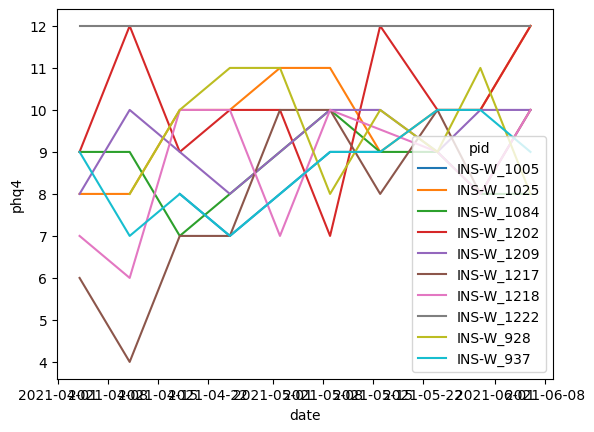

In [9]:
# slice valid_pids in dep_weekly_new
valid_pids_deps = dep_weekly_new[dep_weekly_new['pid'].isin(valid_pids)]
# visualize phq4 score, x is date, y is phq4, label pid, use sns
sns.lineplot(data=valid_pids_deps, x='date', y='phq4', hue='pid')

In [10]:
# exclude INS-W_1222 by visual analysis: phq4 score is always 12
valid_pids.remove('INS-W_1222')

<Axes: xlabel='date', ylabel='phq4'>

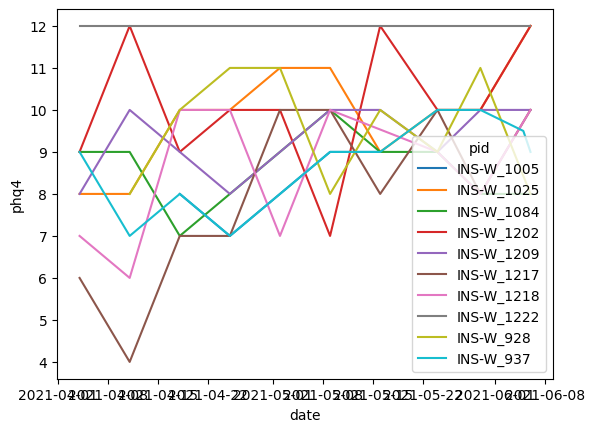

In [11]:
# First, sort by person and date to ensure correct ordering for interpolation
# Replace 'date' with your actual date or sequence column if it's named differently
valid_pids_deps = valid_pids_deps.sort_values(by=['pid', 'date'])

# Now, group by 'pid' and then interpolate the 'phq4' column for each person
valid_pids_deps['phq4'] = valid_pids_deps.groupby(
    'pid')['phq4'].transform(lambda x: x.interpolate())

sns.lineplot(data=valid_pids_deps, x='date', y='phq4', hue='pid')

## Step 2: Extract passive sensing data for the selected participants

**Heuristics**
* Do data transformation to derive human-interpretable, meaningful features
* Use the lowest granularity of data possible (e.g., hourly, parts of day, daily)

In [12]:
wifiData = load_single_file_csv("data_raw/INS-W_4/", "FeatureData", "wifi.csv", valid_pids)
wifiData = filter_dates(wifiData, date_range[4]["start"], date_range[4]["end"])

# Define the specific keywords for the time-of-day segments
time_keywords = [":morning", ":afternoon", ":evening", ":night"]

wifiUseColumns = [
    col for col in wifiData.columns
    if (
        # Always include these exact match columns
        col.lower() in ["pid", "date"]
        or
        (
            # For other columns, must meet ALL these conditions:
            # Contains a time segment
            any(keyword in col.lower() for keyword in time_keywords)
            # AND contains one of our target metrics
            and ("uniquedevices" in col.lower() or "countscansmostuniquedevice" in col.lower())
            # AND doesn't contain excluded terms
            and "norm" not in col.lower()
            and "dis" not in col.lower()
        )
    )
]

print(wifiUseColumns)

# Slice wifiData with the corrected list of columns
wifiData = wifiData[wifiUseColumns]
# wifiData.head()

['pid', 'date', 'f_wifi:phone_wifi_connected_rapids_uniquedevices:afternoon', 'f_wifi:phone_wifi_connected_rapids_countscansmostuniquedevice:afternoon', 'f_wifi:phone_wifi_connected_rapids_uniquedevices:evening', 'f_wifi:phone_wifi_connected_rapids_countscansmostuniquedevice:evening', 'f_wifi:phone_wifi_connected_rapids_uniquedevices:morning', 'f_wifi:phone_wifi_connected_rapids_countscansmostuniquedevice:morning', 'f_wifi:phone_wifi_connected_rapids_uniquedevices:night', 'f_wifi:phone_wifi_connected_rapids_countscansmostuniquedevice:night']


In [13]:
uniquedevices = wifiData.melt(
    id_vars=["pid", "date"],
    value_vars=[col for col in wifiData.columns if 'uniquedevices' in col],
    value_name="uniquedevices"
)
uniquedevices['segment'] = uniquedevices['variable'].str.extract(
    r':(morning|afternoon|evening|night)$')

# Then melt for countscans (if these columns exist)
countscans = wifiData.melt(
    id_vars=["pid", "date"],
    value_vars=[
        col for col in wifiData.columns if 'countscansmostuniquedevice' in col],
    value_name="countscansmostuniquedevice"
)
countscans['segment'] = countscans['variable'].str.extract(
    r':(morning|afternoon|evening|night)$')

# Merge them together
wifiData_long = pd.merge(
    uniquedevices[['pid', 'date', 'segment', 'uniquedevices']],
    countscans[['pid', 'date', 'segment', 'countscansmostuniquedevice']],
    on=['pid', 'date', 'segment'],
    how='outer'  # Use 'outer' to keep all records even if one metric is missing
)

# Mapping from segments to times (6AM, 12PM, 6PM, 12AM)
segment_to_time = {
    'morning': '05:59:59',    # 6AM
    'afternoon': '11:59:59',  # 12PM (noon)
    'evening': '17:59:59',    # 6PM
    'night': '23:59:59'       # 12AM (midnight)
}

# Convert the date column to datetime if it isn't already
wifiData_long['date'] = pd.to_datetime(wifiData_long['date'])

# Assign the appropriate time to each segment
wifiData_long['datetime'] = wifiData_long.apply(
    lambda row: row['date'].replace(
        hour=int(segment_to_time[row['segment']].split(':')[0]),
        minute=int(segment_to_time[row['segment']].split(':')[1]),
        second=int(segment_to_time[row['segment']].split(':')[2])
    ),
    axis=1
)

wifiData_long.head()

,pid,date,segment,uniquedevices,countscansmostuniquedevice,datetime
0,INS-W_1005,2021-03-29,afternoon,4.0,NaN,2021-03-29 11:59:59
1,INS-W_1005,2021-03-29,evening,9.0,NaN,2021-03-29 17:59:59
2,INS-W_1005,2021-03-29,morning,13.0,NaN,2021-03-29 05:59:59
3,INS-W_1005,2021-03-29,night,3.0,NaN,2021-03-29 23:59:59
4,INS-W_1005,2021-03-30,afternoon,8.0,NaN,2021-03-30 11:59:59


In [14]:
# Address data MAR (missing at random): linear inputation
# First ensure your data is sorted properly before interpolation
wifiData_long = wifiData_long.sort_values(['pid', 'datetime'])

# Define the numeric columns you want to interpolate
# Being explicit is better than interpolating all numeric columns
cols_to_interpolate = ['uniquedevices', 'countscansmostuniquedevice']

# Set 'datetime' as the index to allow for time-based interpolation
wifiData_long = wifiData_long.set_index('datetime')

# Group by 'pid' and 'segment'; time and linear is essentially the same because the interval is assigned the same
wifiData_long[cols_to_interpolate] = wifiData_long.groupby(['pid', 'segment'])[cols_to_interpolate].transform(
    lambda x: x.interpolate(method='time', limit_direction='both')
)

# Reset the index to bring 'datetime' back as a column
wifiData_long = wifiData_long.reset_index()

# Ensure the final DataFrame has the desired column order
wifiData_long = wifiData_long[['pid', 'date', 'segment',
                               'uniquedevices', 'countscansmostuniquedevice', 'datetime']]

wifiData_long.head()

,pid,date,segment,uniquedevices,countscansmostuniquedevice,datetime
0,INS-W_1005,2021-03-29,morning,13.0,90.0,2021-03-29 05:59:59
1,INS-W_1005,2021-03-29,afternoon,4.0,1.0,2021-03-29 11:59:59
2,INS-W_1005,2021-03-29,evening,9.0,11.0,2021-03-29 17:59:59
3,INS-W_1005,2021-03-29,night,3.0,40.0,2021-03-29 23:59:59
4,INS-W_1005,2021-03-30,morning,3.0,90.0,2021-03-30 05:59:59


<Axes: xlabel='datetime', ylabel='uniquedevices'>

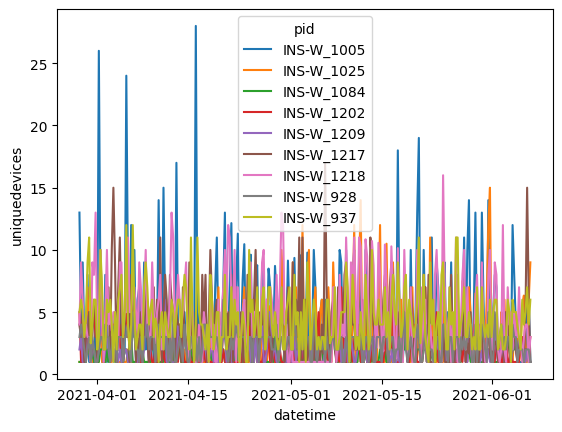

In [15]:
# visualize x = datetime, y = uniquedevices, label pid, use sns
sns.lineplot(data=wifiData_long, x='datetime', y='uniquedevices', hue='pid')

<Axes: xlabel='datetime', ylabel='countscansmostuniquedevice'>

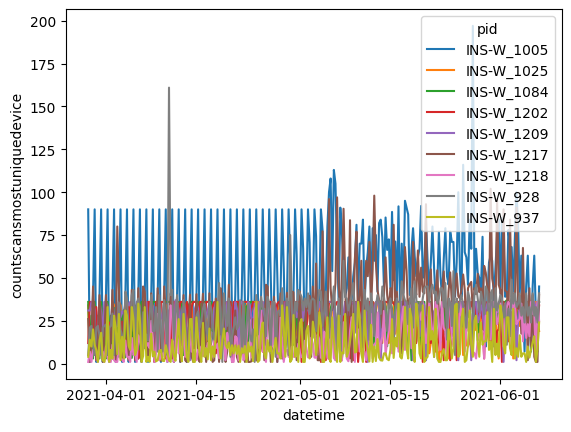

In [16]:
# visualize x = datetime, y = countscansmostuniquedevice, label pid, use sns
sns.lineplot(data=wifiData_long, x='datetime',
             y='countscansmostuniquedevice', hue='pid')

In [17]:
# export to csv
wifiData_long.to_csv('data_processed/wifiData_long.csv', index=False)